In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

shipsnet_path = path + r"\\shipsnet.json"

Path to dataset files: C:\Users\wwden\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [49]:
import json

with open(shipsnet_path) as f:
    data = json.load(f)  # NOT json.dumps()

def print_structure(d, indent=0):
    prefix = '  ' * indent
    if isinstance(d, dict):
        for k, v in d.items():
            print(f"{prefix}{k}: {type(v).__name__}")
            print_structure(v, indent + 1)
    elif isinstance(d, list):
        print(f"{prefix}list[{len(d)}]: {type(d[0]).__name__}" if d else f"{prefix}list: empty")
        if d:
            print_structure(d[0], indent + 1)

print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


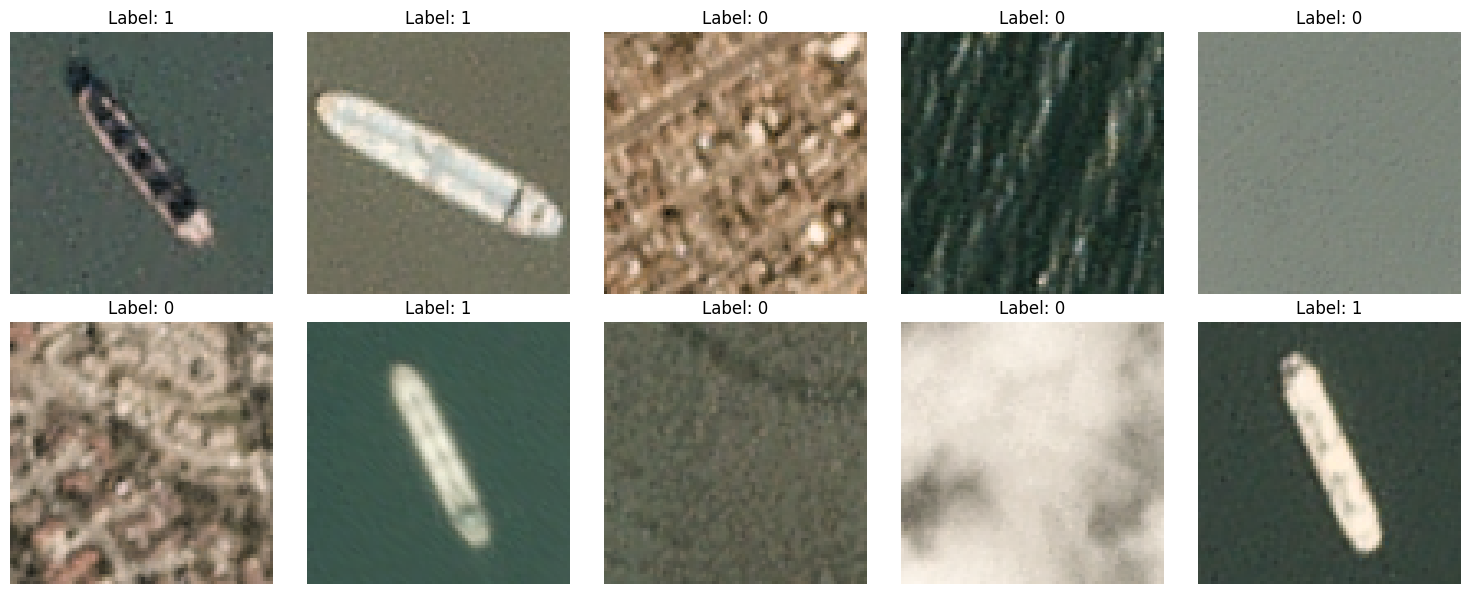

In [50]:
import numpy as np
import matplotlib.pyplot as plt

X_data = np.array(data["data"][:2000])
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1) / 255

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0,2000,size = 10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow(X_data_transformed[idx])
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [51]:
import os
import sys

# Save current working directory
cwd = os.getcwd()

# Change to parent directory
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
os.chdir(parent_dir)

# Temporarily add parent directory to sys.path
sys.path.insert(0, parent_dir)
import framework
sys.path.pop(0)

# Return to original directory
os.chdir(cwd)


In [52]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from CNN import CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN(F.relu, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float('inf')

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 1.2:
        print("Stopping early due to loss increase")
        break

    best_loss = avg_loss

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cuda
Epoch 1 completed, Avg Loss: 0.6396, Accuracy: 67.62%
Epoch 2 completed, Avg Loss: 0.3598, Accuracy: 84.69%
Epoch 3 completed, Avg Loss: 0.2198, Accuracy: 93.00%
Epoch 4 completed, Avg Loss: 0.1353, Accuracy: 95.62%
Epoch 5 completed, Avg Loss: 0.0914, Accuracy: 96.94%
Epoch 6 completed, Avg Loss: 0.0913, Accuracy: 96.56%
Epoch 7 completed, Avg Loss: 0.0730, Accuracy: 97.69%
Epoch 8 completed, Avg Loss: 0.0660, Accuracy: 97.88%
Epoch 9 completed, Avg Loss: 0.0585, Accuracy: 98.06%
Epoch 10 completed, Avg Loss: 0.0602, Accuracy: 98.56%
Epoch 11 completed, Avg Loss: 0.0500, Accuracy: 98.19%
Epoch 12 completed, Avg Loss: 0.0575, Accuracy: 98.44%
Epoch 13 completed, Avg Loss: 0.0518, Accuracy: 98.25%
Epoch 14 completed, Avg Loss: 0.0583, Accuracy: 98.00%
Epoch 15 completed, Avg Loss: 0.0647, Accuracy: 98.25%
Epoch 16 completed, Avg Loss: 0.0413, Accuracy: 98.75%
Epoch 17 completed, Avg Loss: 0.0289, Accuracy: 98.94%
Epoch 18 completed, Avg Loss: 0.0468, Accuracy: 98.56%
Stopping early

In [53]:
from framework.attack import Injector
from framework.criterion import multiclass_classification_accuracy

pred = model(X_test.to(device))

baseline = multiclass_classification_accuracy(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
baseline

0.9725

In [54]:
crit = lambda a,b : multiclass_classification_accuracy(a.cpu().detach().numpy(), b.cpu().detach().numpy())

inj = Injector(model, X_test, y_test, crit, "cuda")

import pandas as pd
df = pd.DataFrame()
for bit in [0,1,3,6,10,15,21]:
    print(bit)

    results = inj.run_seu(bit,)

    res = pd.DataFrame(results)
    res["bit_i"] = bit
    df = pd.concat([df, res])

df

Testing a forward pass on cuda...
Basline Criterion Score: 0.9725
0


216it [00:01, 184.56it/s]
8it [00:00, 183.61it/s]
1152it [00:06, 185.02it/s]
16it [00:00, 172.59it/s]
2366it [00:12, 189.15it/s]


KeyboardInterrupt: 

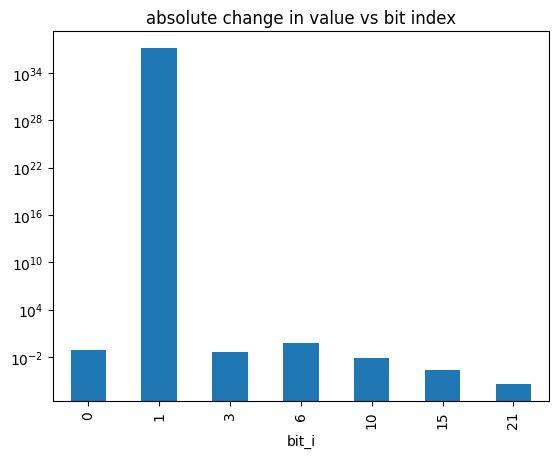

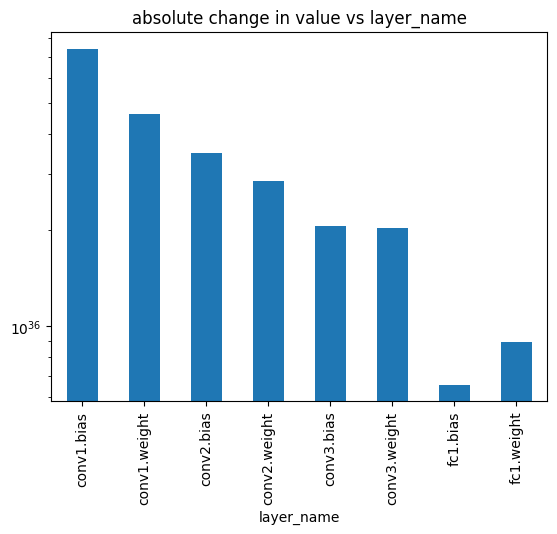

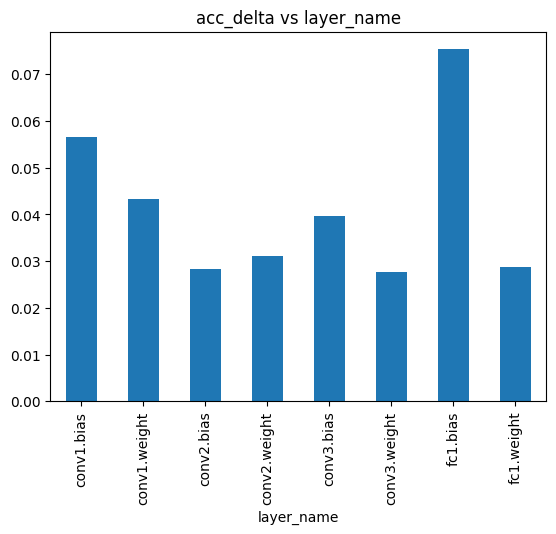

In [ ]:
df["value_delta"] = abs(df["value_before"] - df["value_after"])
df["acc_delta"] = baseline - df["criterion_score"]
df.describe()

df.groupby("bit_i")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs bit index")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs layer_name")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["acc_delta"].mean().plot(kind = "bar", title = "acc_delta vs layer_name")
plt.show()

In [ ]:
# df.to_parquet("results/shipsnet_relu0_cnn.gzip", compression="gzip")

(array([  1.,   2.,   8.,  11.,  27.,  31.,  66., 127., 187., 296., 398.,
        546., 658., 772., 787., 743., 675., 576., 457., 389., 297., 186.,
        147.,  81.,  62.,  42.,  15.,  20.,  10.,   6.,   4.,   1.,   3.,
          0.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.24601185, -0.2287026 , -0.21139337, -0.19408412, -0.17677489,
        -0.15946564, -0.14215641, -0.12484716, -0.10753792, -0.09022868,
        -0.07291944, -0.05561019, -0.03830095, -0.02099171, -0.00368247,
         0.01362677,  0.03093601,  0.04824525,  0.0655545 ,  0.08286374,
         0.10017298,  0.11748222,  0.13479146,  0.15210071,  0.16940995,
         0.18671919,  0.20402843,  0.22133768,  0.23864691,  0.25595614,
         0.27326539,  0.29057464,  0.30788389,  0.32519314,  0.34250236,
         0.3598116 ,  0.37712085,  0.3944301 ,  0.41173932,  0.42904857,
         0.44635782]),
 <BarContainer object of 40 artists>)

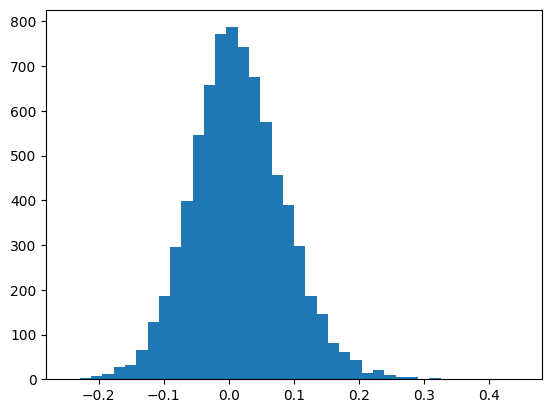

In [55]:
model_weights = []

for name, tensor in model.state_dict().items():
    arr = tensor.cpu().detach().numpy()
    for val in np.ravel(arr):
        model_weights.append(val)

plt.hist(model_weights, bins = 40)

c:\Repositories\seu-injection-framework\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


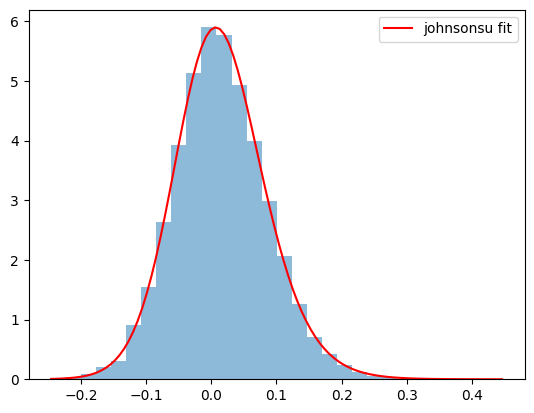

,distribution,params,p_value
0,johnsonsu,"(-0.9382359782105237, 3.2749896918699157, -0.0...",9.004033e-01
1,lognorm,"(0.07659993169412566, -0.9138424079558417, 0.9...",3.940188e-01
2,fisk,"(20.486915030255943, -0.808680495005001, 0.820...",1.233598e-01
3,t,"(15.576137315854295, 0.014040654677781268, 0.0...",2.410600e-02
4,invgauss,"(0.01500956739712785, -0.5749864254004129, 39....",1.126493e-03
5,norm,"(0.014976949, 0.071326345)",4.287928e-04
6,genextreme,"(0.14346889318059158, -0.014732165337417422, 0...",2.797152e-05
7,laplace,"(0.011297248, 0.05588896673700714)",1.141050e-13
8,gumbel_r,"(-0.019878076818868804, 0.06852380931377404)",4.083946e-20
9,genpareto,"(-0.7023616792074631, -0.2460118457795103, 0.4...",0.000000e+00


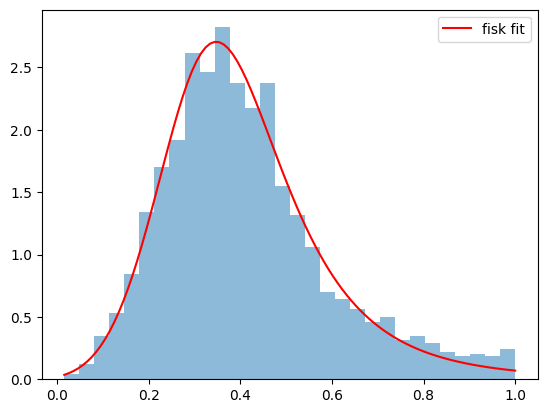

,distribution,params,p_value
0,fisk,"(5.1439433899184674, -0.10985992583934068, 0.4...",1.798570e-04
1,gumbel_r,"(0.3295058635259064, 0.14551772734377744)",4.464628e-08
2,johnsonsu,"(-3.912960953668872, 2.793388051575777, -0.027...",2.499178e-09
3,genextreme,"(0.03143336689557866, 0.3319736542702081, 0.14...",8.005303e-10
4,lognorm,"(0.30463669869117965, -0.16972850491161962, 0....",4.187614e-12
5,invgauss,"(0.09153793245241906, -0.1853717953083978, 6.5...",3.499048e-14
6,t,"(5.740772983012312, 0.3940050756242409, 0.1491...",3.510351e-33
7,laplace,"(0.3843137254901961, 0.13753882352941174)",8.517486e-56
8,norm,"(0.4125149019607843, 0.1814480946773844)",7.845505e-110
9,genpareto,"(-0.591787891791106, 0.015686268040700863, 0.5...",0.000000e+00


In [81]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

def fit_distributions(data, plot_best=True):
    distributions = [
    stats.norm, stats.t, stats.laplace,
    stats.lognorm, stats.invgauss, stats.fisk,
    stats.genextreme, stats.genpareto,
    stats.johnsonsu, stats.gumbel_r
]
    
    results = []

    for dist in distributions:
        try:
            params = dist.fit(data)
            D, p = stats.kstest(data, dist.cdf, args=params)
            results.append({
                'distribution': dist.name,
                'params': params,
                'p_value': p
            })
        except Exception as e:
            results.append({
                'distribution': dist.name,
                'params': None,
                'p_value': np.nan
            })

    df = pd.DataFrame(results)
    df = df.sort_values(by='p_value', ascending=False).reset_index(drop=True)

    if plot_best and not df['p_value'].isna().all():
        best = df.iloc[0]
        dist_obj = getattr(stats, best['distribution'])
        params = best['params']
        if len(params) == 2:
            loc, scale = params
            shape_args = ()
        elif len(params) == 3:
            shape_args = (params[0],)
            loc, scale = params[1], params[2]
        else:
            shape_args = params[:-2]
            loc, scale = params[-2], params[-1]

        x = np.linspace(min(data), max(data), 100)
        pdf = dist_obj(*shape_args, loc=loc, scale=scale).pdf(x)
        plt.hist(data, bins=30, density=True, alpha=0.5)
        plt.plot(x, pdf, 'r-', label=f'{best["distribution"]} fit')
        plt.legend()
        plt.show()

    return df

df_results = fit_distributions(model_weights)
display(df_results)

X_arr = np.ravel(X_data_transformed)
sample_X = X_arr[np.random.choice(len(X_arr), size=20_000, replace=False)]
df_results = fit_distributions(sample_X)
display(df_results)